In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embedding_generation import EmbeddingGenerator, NLI

In [2]:
wiki_dataset = WikiDataset(reduced=True, type='train', in_mem=True, num_extra_pages=500000, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8192, num_workers=8, shuffle=False)

In [3]:
vdb = VectorDatabase(client='docker', wiki_loader=wiki_dataloader)

Creating collection
Block 1/63 done
Block 2/63 done
Block 3/63 done
Block 4/63 done
Block 5/63 done
Block 6/63 done
Block 7/63 done
Block 8/63 done
Block 9/63 done
Block 10/63 done
Block 11/63 done
Block 12/63 done
Block 13/63 done
Block 14/63 done
Block 15/63 done
Block 16/63 done
Block 17/63 done
Block 18/63 done
Block 19/63 done
Block 20/63 done
Block 21/63 done
Block 22/63 done
Block 23/63 done
Block 24/63 done
Block 25/63 done
Block 26/63 done
Block 27/63 done
Block 28/63 done
Block 29/63 done
Block 30/63 done
Block 31/63 done
Block 32/63 done
Block 33/63 done
Block 34/63 done
Block 35/63 done
Block 36/63 done
Block 37/63 done
Block 38/63 done
Block 39/63 done
Block 40/63 done
Block 41/63 done
Block 42/63 done
Block 43/63 done
Block 44/63 done
Block 45/63 done
Block 46/63 done
Block 47/63 done
Block 48/63 done
Block 49/63 done
Block 50/63 done
Block 51/63 done
Block 52/63 done
Block 53/63 done
Block 54/63 done
Block 55/63 done
Block 56/63 done
Block 57/63 done
Block 58/63 done
Blo

In [4]:
fever_collator = FeverCollator()
fever_dataset = FeverDataset(type='dev')
fever_loader = DataLoader(fever_dataset, batch_size=32, num_workers=10, shuffle=False, collate_fn=fever_collator)

emb_gen = EmbeddingGenerator()
nli = NLI()

In [55]:
fever_dataset[1]

{'id': 150448,
 'verifiable': 'VERIFIABLE',
 'label': 'SUPPORTS',
 'claim': 'Roman Atwood is a content creator.',
 'evidence': {'all_evidence': ['Roman_Atwood'],
  'unique_evidence': [{'Roman_Atwood'}]}}

In [5]:
import torch
from train_eval_utils import get_target_changes, get_negative_examples, get_metrics
from other_utils import print_progress
import time
import numpy as np

PAGES_RETRIEVED = 50
PAGES_FOR_EVIDENCE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn1 = torch.nn.CosineEmbeddingLoss()
loss_fn2 = torch.nn.BCELoss()

# get embeddings of the claims
emb_gen.eval()
nli.eval()

tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  []}

results = []
for i, input_batch in enumerate(fever_loader):
    if i == 1:
        break
    batch_size = len(input_batch['claims'])
    init = time.time()
    with torch.no_grad():
        outputs = emb_gen(input_batch['claims'])

    print('Embedding generation time:', (time.time() - init)*1000, 'ms')

    init = time.time()
    # search for similar pages
    similar_pages = vdb.search_similar(outputs, PAGES_RETRIEVED, with_payload=True)
    print('   Search time:', (time.time() - init)*1000, 'ms')

    similar_texts = []
    similar_ids = []
    for s in similar_pages:
        similar_texts.append([t.payload['text'] for t in s])
        similar_ids.append([t.payload['id'] for t in s])

    target_changes, percentage_retrieved = get_target_changes(input_batch, similar_ids, PAGES_FOR_EVIDENCE)
    origibal_nli_targets = [int(v == 'VERIFIABLE') for v in input_batch['verifiable']]

    # dinamically change the target
    #---------------------------------- only training
    dynamic_nli_targets = [int(t and tc) for t, tc in zip(origibal_nli_targets, target_changes)]
    #---------------------------------- only training

    all_evidence = [r['all_evidence'] if r['all_evidence'] != [None] else [] for r in input_batch['evidence']]
    init2 = time.time()
    evidence_pages = [vdb.search_ids(all_evidence[i]) for i in range(batch_size)]
    print('   Evidence search time:', (time.time() - init2)*1000, 'ms')
    evidence_texts = [[t.payload['text'] for t in s] for s in evidence_pages]
    # pick as negative examples the texts of the last len(evidence_texts) of the 50 retrieved pages
    negative_examples = get_negative_examples(similar_texts, similar_ids, all_evidence)

    print('Retrieval time:', (time.time() - init)*1000, 'ms')
    init = time.time()
    # combine all the batches
    unfolded_outputs = []
    unfolded_combined_texts = []
    unfolded_labels = []
    for i in range(batch_size):
        unfolded_outputs.extend([outputs[i]] * (len(evidence_texts[i]) + len(negative_examples[i])))
        unfolded_combined_texts.extend(evidence_texts[i] + negative_examples[i])
        unfolded_labels.extend([1] * len(evidence_texts[i]) + [0] * len(negative_examples[i]))

    # encode the combined texts in batches
    combined_embeddings = []
    for i in range(0, len(unfolded_combined_texts), batch_size):
        with torch.no_grad():
            combined_embeddings.extend(emb_gen(unfolded_combined_texts[i:i+batch_size]))


    combined_embeddings = torch.tensor(np.array(combined_embeddings)).to(device)
    unfolded_outputs = torch.tensor(np.array(unfolded_outputs)).to(device)
    unfolded_labels = torch.tensor(np.array(unfolded_labels)).to(device)

    loss1 = loss_fn1(combined_embeddings, unfolded_outputs, unfolded_labels)

    print('Re embedding generation time:', (time.time() - init)*1000, 'ms')
    init = time.time()

    # input for the NLI model
    
    similar_embeddings = vdb.search_similar(outputs, PAGES_FOR_EVIDENCE, with_vector=True)
    similar_embeds = [[t.vector for t in s] for s in similar_embeddings]
    print('   Similar search time:', (time.time() - init)*1000, 'ms')
    similar_embeds = torch.tensor(np.array(similar_embeds))
    outputs = torch.tensor(outputs).unsqueeze(1)

    # concat the output of the embedding generator
    nli_inputs = torch.cat([outputs, similar_embeds], dim=1).to(device)

    init2 = time.time()
    with torch.no_grad():
        nli_outputs = nli(nli_inputs.half())

    init2 = time.time()
    preds = torch.argmax(nli_outputs, dim=1).cpu().numpy()
    targets = torch.tensor(dynamic_nli_targets).half().to(device)

    # nli_outputs is 32,2 keep only the 1
    nli_outputs = nli_outputs[:, 1]

    # Convert lists of tensors to tensors
    loss2 = loss_fn2(nli_outputs, targets)

    print('NLI time:', (time.time() - init)*1000, 'ms')
    
    result = {'preds': preds, 
              'original_labels': origibal_nli_targets, 
              'dynamic_labels': dynamic_nli_targets, 
              'percentage_retrieved': percentage_retrieved,
              'loss1': loss1.item(),
              'loss2': loss2.item()}

    print(result)
    results.append(result)
    #------------------------------------------------------------

metrics = get_metrics(results)

for k, v in metrics.items():
    tracking_eval[k].append(v)

#print_progress(epoch=1, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)



Embedding generation time: 15.275239944458008 ms
   Search time: 85.26086807250977 ms
   Evidence search time: 41.786909103393555 ms
Retrieval time: 127.49886512756348 ms
Re embedding generation time: 163.9723777770996 ms
   Similar search time: 115.8759593963623 ms
NLI time: 151.34787559509277 ms
{'preds': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1]), 'original_labels': [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], 'dynamic_labels': [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'percentage_retrieved': [1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0], 'loss1': 0.12933416664600372, 'loss2': 0.70703125}


Epoch: 1
Batch: 1/1


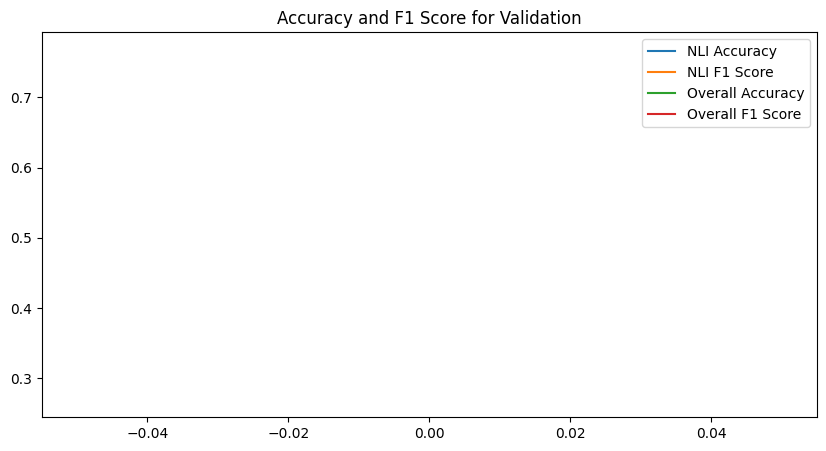

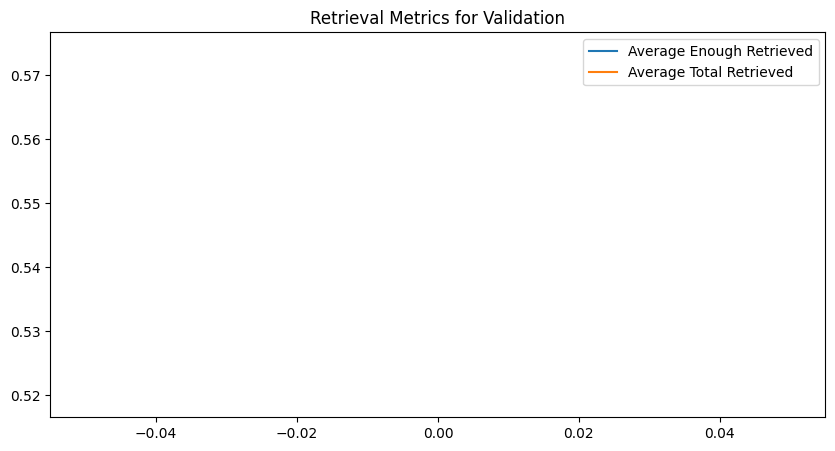

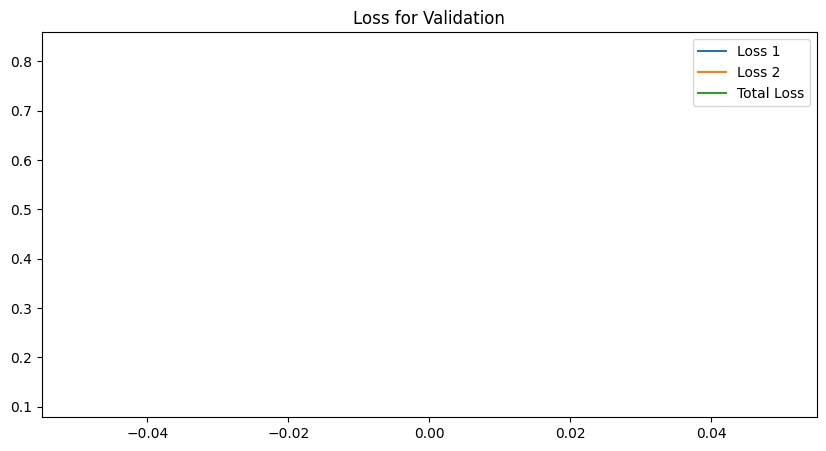

True

In [6]:
from validation import Validation

tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  []}

val = Validation(device=device, eval_loader=fever_loader, vdb=vdb, emb_gen=emb_gen, nli=nli, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')

val.valid_epoch(epoch=1, tracking_eval=tracking_eval)